In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import ipywidgets as widgets
from scipy.signal import butter, lfilter
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import freqz
from IPython.display import display, HTML

%matplotlib widget

### Define plotting functions ###

In [17]:
def plot_audio_time_domain(audio, sample_rate):

    channels = audio.shape[1] if audio.ndim > 1 else 1
    time = np.linspace(0., len(audio) / sample_rate, len(audio))

    plt.figure(figsize=(15, 5))
    for i in range(channels):
        plt.subplot(2, 1, i+1)
        plt.plot(time, audio[:, i])
        plt.title('Channel %d' % (i+1))
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()



def plot_audio_freq_domain(audio, sample_rate):
    channels = audio.shape[1] if audio.ndim > 1 else 1
    plt.figure(figsize=(15, 5))
    for i in range(channels):
        channel_data = audio[:, i]
        
        #FFT
        yf = fft(channel_data)
        xf = np.linspace(0, sample_rate//2, len(channel_data)//2)
        
        idx_range = np.where(xf<=10000)
        xf_zoom = xf[idx_range]
        yf_zoom = yf[idx_range]
        plt.subplot(2, 1, i+1)
        plt.plot(xf_zoom, 2.0/len(channel_data) * np.abs(yf_zoom))
        
        plt.title('Frequency Domain of Channel %d' % (i+1))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()



def plot_filter_frequency_response(b, a, fs, axis, label):
    # Plot the frequency response of the filter.
    w, h = freqz(b, a, worN=8000)
    w = w * fs / (2 * np.pi)  # Convert from rad/sample to Hz

    axis.plot(w, 20 * np.log10(np.abs(h)), label=label)

### Read audio data ###

In [18]:
sample_rate, audio = wavfile.read(r"./376199__matrixxx__airport-01.wav")

/var/folders/rv/4mmpnqxs5j10y9rblkr909nr0000gn/T/ipykernel_15714/280177937.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read(r"./376199__matrixxx__airport-01.wav")


### Define butterworth filter ###

In [19]:
def butter_lowpass_filter(audio, cutoff, fs, order=1):
    num, den = butter(order, cutoff, btype="low", analog=False, output="ba", fs=fs)    
    if audio.ndim == 1:  # Mono audio
        audio_filtered = lfilter(num, den, audio)
    else:  # Stereo audio
        audio_filtered = np.vstack([
            lfilter(num, den, audio[:, 0]),
            lfilter(num, den, audio[:, 1])
        ]).T  # Transpose back to the original shape
    return audio_filtered

def plot_butter_lowpass(cutoff, fs):

    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot the frequency response for each filter order
    for order in range(1, 11):
        num, den = butter(order, cutoff, btype="low", analog=False, output="ba", fs=fs)
        plot_filter_frequency_response(num, den, fs, ax, f'Order {order}')
    
    # Finalize the plot
    ax.set_title('Butterworth Filter Frequency Responses')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Gain [dB]')
    ax.grid()
    ax.legend()
    plt.show()
        

### Plot and compare lowpass Butterworth filter for 1th to 10th order ###

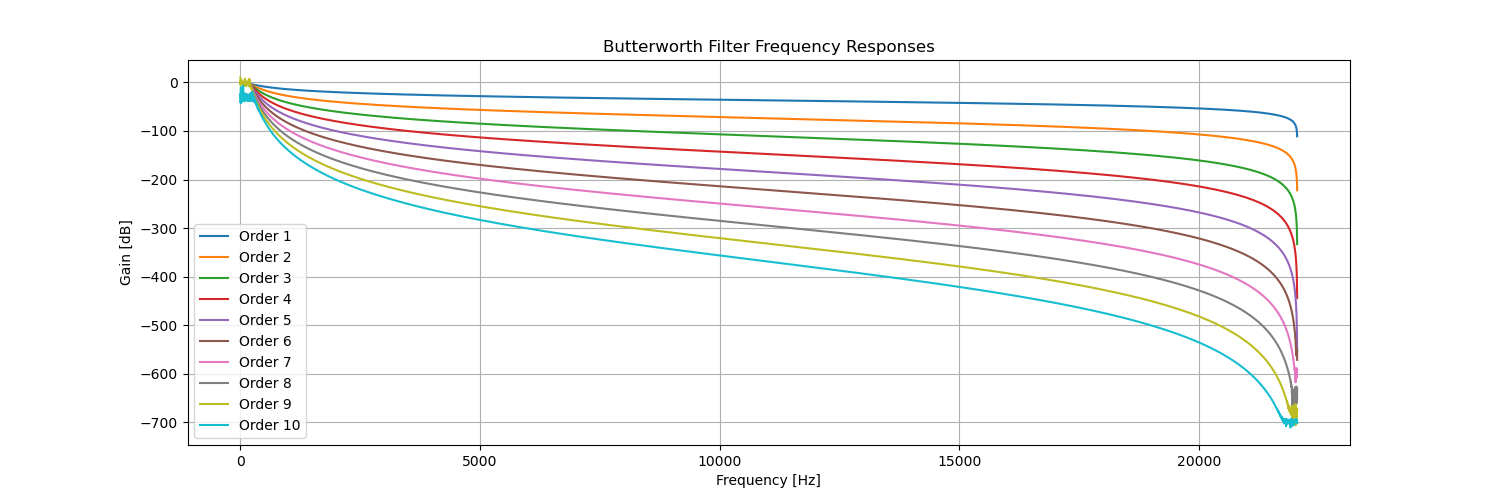

In [20]:
plot_butter_lowpass(200, sample_rate)

### Filter Audio ###


In [21]:
y_low = butter_lowpass_filter(audio, 200, sample_rate, 5)

### Plot original audio (frequency domain) ###

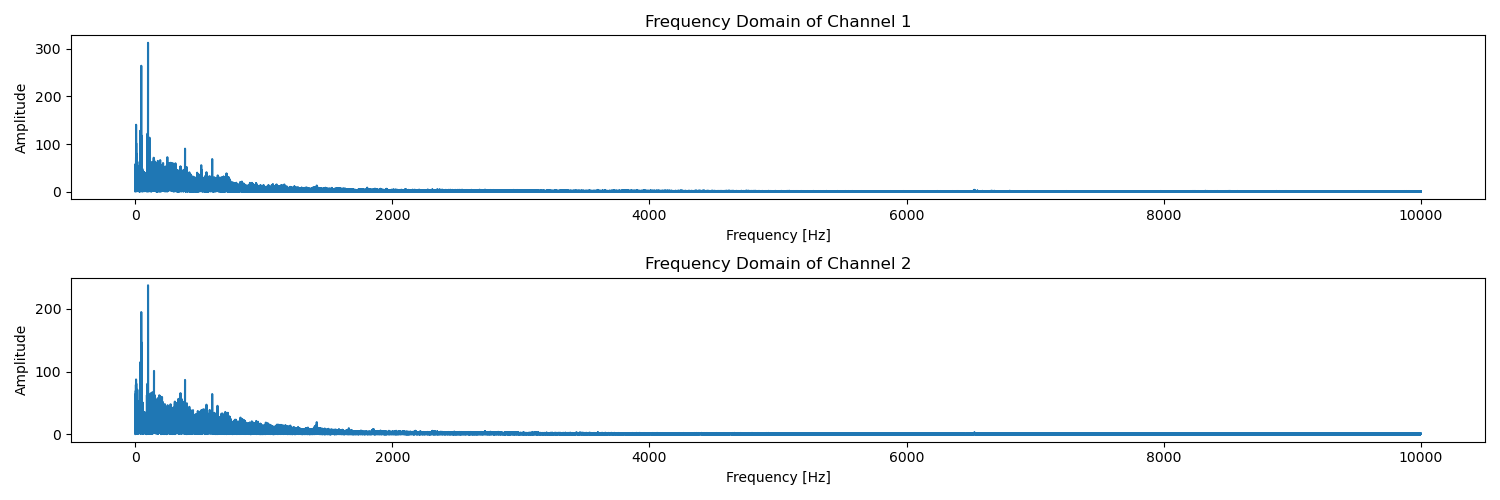

In [22]:
plot_audio_freq_domain(audio, sample_rate)

### Plot filtered audio (frequency domain) ###

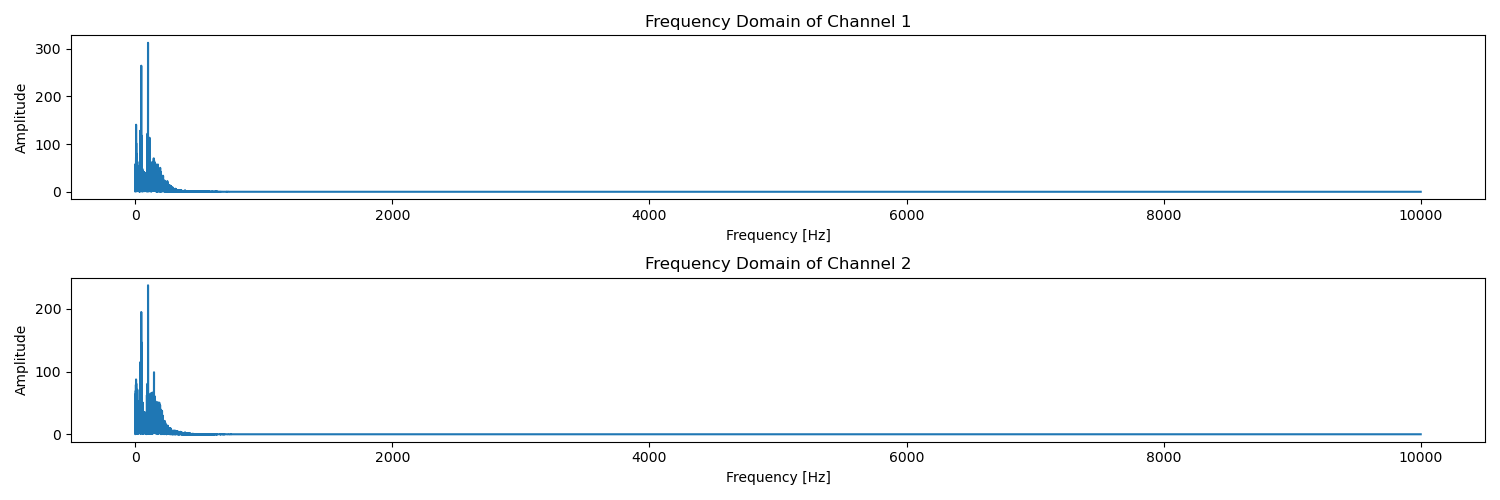

In [23]:
plot_audio_freq_domain(y_low, sample_rate)

### Define Audio Player Widgets ###

In [24]:
# Play audio
def play_audio(audio, sample_rate):
    sd.play(audio, sample_rate)

# Stop audio
def stop_audio():
    sd.stop()

# Button widgets
play_original = widgets.Button(description="Play Original Audio")
play_original.layout = widgets.Layout(border='1px solid black', border_radius='10px')


play_filtered = widgets.Button(description="Play Filtered Audio")
play_filtered.layout = widgets.Layout(border='1px solid black', border_radius='10px')


stop_button = widgets.Button(description="Stop Audio")
stop_button.layout = widgets.Layout(border='1px solid black', border_radius='10px')

# Event handlers
def on_play_original_click(b):
    play_audio(audio, sample_rate)

def on_play_low_filtered_click(b):
    play_audio(y_low, sample_rate)

def on_stop_button_click(b):
    stop_audio()

# Link buttons to event handlers
play_original.on_click(on_play_original_click)
play_filtered.on_click(on_play_low_filtered_click)
stop_button.on_click(on_stop_button_click)

# Custom CSS to style the ipywidget buttons
custom_css = """
<style>
    .jupyter-widgets button {
        background-color: white !important;
        border: 1px solid black !important;
        border-radius: 10px !important;
        margin: 10px;
    }
</style>
"""

# Display the custom CSS
display(HTML(custom_css))


### Play original audio ###

In [25]:
# Group the buttons in a horizontal box
buttons_box_1 = widgets.HBox([play_original, stop_button])
buttons_box_1.layout.justify_content = 'flex-start'

# Display buttons
display(buttons_box_1)

### Play filtered audio ###

In [26]:
# Group the buttons in a horizontal box
buttons_box_2 = widgets.HBox([play_filtered, stop_button])
buttons_box_2.layout.justify_content = 'flex-start'

#Display buttons
display(buttons_box_2)